Matrix factorization
=======================


Matrix factorization is a technique used to decompose a matrix into two smaller matrices, so that the multiplication of these matrices is equal to the original matrix.

One of the popular applications of this technique are recommender systems, where MF is used to extract common hidden features shared between each user (first axis of the matrix) and item to be recommended (second axis), which explain the interactions between them. Those features need to be inferred from the data. This approach is described wider in [the article](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf).

![image.png](https://miro.medium.com/max/3378/0*k0m45RKFE7YN3UHf.png)

The original matrix shape is $m \times n$. The result should be two matrices:
  *  of shape $m \times d$
  *  of shape $d \times n$
where $d$ is chosen to compromise on computation efficiency and number of features required to represent the data.

The value $\hat{r}_{ui}$ from the original matrix (originally - a matrix of ratings of items) is calculated as the dot product of a single row from the first matrix $p_u$ (vector representing a user) and a single column of the second one $q_i$ (vector representing an item).

$$\hat{r}_{ui} = q_i^T p_u$$

To learn the factor vectors $\mathbf{p}$ and $\mathbf{q}$ one can use for example Mean Squared Error:

$$MSE = \sum_{(u, i)\in \mathcal{K}} \left(r_{ui} - q_i^T p_u\right)^2$$

where $\mathcal{K}$ is the set of $(u, i)$ pairs, for which the true $r_{ui}$ is known.


To avoid overfitting, various **regularizations** can be used, such as **L2 regularization** (*ridge regression*):

$$L2 = \sum_{j=0}^p \beta_j^2$$

The L2 term, added with coefficient $\lambda$ to the loss function encourages the params $\beta_j$ to be small. 

In [1]:
import torch
import numpy as np
from tqdm.notebook import trange
import matplotlib.pyplot as plt


Homework
-------------


1. Create a class inheriting from `torch.nn.Module`. Declare $\mathbf{p}$ and $\mathbf{q}$ matrices and set their sizes according to the passed params. Define `forward(self)` method to return a dot product of the matrices.
2. Create a basic loss function (which will be , according to the equation:
$$L = MSE + \lambda \cdot L2$$
   You might implement your own functions or use the PyTorch builtins.
   > *NOTE*: most PyTorch optimizers already include L2 regularization, controlled by `weight_decay` param, but we will not be using it here.
3. Create a function `train` that will train the model for a given number of epochs, with a given learning rate. Enable passing the source matrix and the model. Train the model on matrix given at the start, with given params. Plot the loss function.
4. Expand the loss function and add additional constraints:
   *  apply L1 regularization
   $$L1 = \sum_{j=0}^p \left|\beta_j\right|$$
   *  encourage the length of each vector (i.e. per one person or item) to be 1
   $$L_{unit} = \sum_{u \in \mathcal{K}} \left| |p_u| - 1\right| + \sum_{i \in \mathcal{K}} \left|\left|q_i\right| - 1\right|$$

   Verify their influence on the achieved loss.
   

In [2]:
"""Task 1"""

class MatrixFactorizer(torch.nn.Module):
    def __init__(self, dim_h, dim_w, n_features):
        """ Initialize the model.
        
        :param dim_h: number of rows in "user" matrix
        :param dim_w: number of columns in "item" matrix
        :param n_features: number of features in both matrices
        """
        super().__init__()
        self.p = torch.rand(dim_h, n_features,requires_grad=True)
        self.q = torch.rand(n_features, dim_w,requires_grad=True)
        
    def forward(self):
        return self.p @ self.q

In [5]:
def test_mf():
    params = {(3, 5, 1): (3, 5),
              (7, 7, 1): (7, 7),
              (49, 35, 3): (49, 35)}
    for (dim_h, dim_w, n_features), (result_h, result_w) in params.items():
        mf = MatrixFactorizer(dim_h, dim_w, n_features)
        assert (mf().size() == (result_h, result_w))


test_mf()

In [6]:
"""Task 2"""
def loss_fn(r, factorizer, rate=0.01):
    """ Calculate the loss.
    
    :param r: the original matrix
    :param mf: the matrix factorizer model, initialized
    :param rate: l2 regularization term rate
    :return: loss function value
    """
    loss = torch.sum((r - factorizer.forward())**2)
    return loss
    
def l2_norm(params):
    return torch.sum(params**2)


In [7]:
def test_l2():
    params = {(3.,): 9.00,
              (0.4, 0.6): 0.52,
              ((0.1, 0.2), (0.4, 0.5)): 0.46}
    for data, result in params.items():
        data = torch.tensor(data, dtype=torch.float)
        result = torch.tensor(result, dtype=torch.float)
        l2 = torch.round(
            100 * l2_norm(data)
        ) / 100
        assert l2 == result
        
test_l2()

In [8]:
"""Task 3"""
def train(model, data,
          num_epochs=10_000,
          lr=1e-3,
          loss_fn=loss_fn):
    
    """ Train MF model.
    
    :param model: MatrixFactorizer model (initialized)
    :param data: matrix to be factorized
    :param num_epochs: number of epochs to perform
    :param lr: used learning rate
    :param loss: loss function (callable)
    :return: loss history
    """
    optimizer = torch.optim.SGD((model.p,model.q), lr=lr)
    losses = []
    for epoch in range(num_epochs):
        preds = model.forward()
        loss = loss_fn(data, model)
        losses.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    fig, ax = plt.subplots()
    ax.set_xlabel("epochs")
    ax.set_ylabel("loss")
    ax.plot(range(num_epochs), losses)
    plt.grid()
    plt.show()

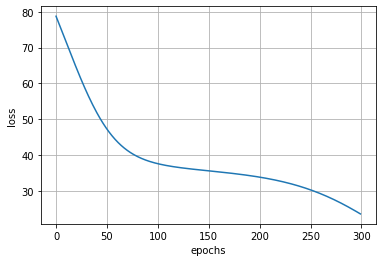

In [10]:
data = torch.tensor([ [0, 4.5, 2.5, 0], [4,0,3.5,0], [0,5,0,2], [0,3.5,4,1]])
model = MatrixFactorizer(4,4,2)

train(model,data,num_epochs=300,loss_fn=loss_fn)

In [33]:
"""Task 4"""
def l1_norm(params):
    return torch.sum(torch.abs(params))

def length_reg(params):
    lenghts = torch.norm(params,dim=1)-1
    lenghts = torch.abs(lenghts)
    res = torch.sum(lenghts.type(torch.float))
    return res

    

In [34]:
def test_l1():
    params = {(3.,): 3.00, (0.4, 0.6): 1.0, (0.1, 0.2, 0.4, 0.5): 1.2}
    for data, result in params.items():
        data = torch.tensor(data, dtype=torch.float)
        result = torch.tensor(result, dtype=torch.float)
        l1 = torch.round(
            100 * l1_norm(data)
        ) / 100
        assert l1 == result
        
test_l1()

In [35]:
def test_length_reg():
    params = {((3.,),): 2.00,
              ((0.4, 0.6),): 0.28,
              ((0.1, 0.2), (0.4, 0.5)): 1.14}
    for data, result in params.items():
        data = torch.tensor(data, dtype=torch.float)
        result = torch.tensor(result, dtype=torch.float)
        reg = torch.round(
            100 * length_reg(data)
        ) / 100
        assert reg == result

test_length_reg()

In [15]:
def loss_fn_reg(r, factorizer, l1_rate=0., l2_rate=0.4, length_rate = 0.2):
    """ Calculate the loss.
    
    :param r: the original matrix
    :param mf: the matrix factorizer model, initialized
    :param l1_rate: l1 regularization term rate
    :param l2_rate: l2 regularization term rate
    :param length_rate: length regularization term rate
    :return: loss function value
    """
    params = torch.cat((factorizer.p.view(-1,1) , factorizer.q.view(-1,1)))
    return loss_fn(r,factorizer) \
            + l1_rate * l1_norm(params) \
            + l2_rate * l2_norm(params) \
            + length_rate * length_reg(params)
